In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import data_prep
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:

# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


In [4]:
X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info, timestamps_train, timestamps_val, timestamps_test = data_prep.prepare_weather_data(
    df, 
    target_col='Radiation',
    window_size=24,  # 24 steps for daily patterns
    log_transform=False,
    use_solar_elevation=False
)

Added 'Radiation_is_low' feature (threshold: 1.2000)
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 16)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 16)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 16)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Radiation_is_low', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'TimeMinutesSin', 'TimeMinutesCos', 'HourOfDay']


In [5]:
X_train[1,:,8]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [6]:
X_combined = np.concatenate([X_train, X_test], axis=0)
timestamps_combined = np.concatenate([timestamps_train, timestamps_test], axis=0)

# Apply PCA transform to all data
X_combined_pca, timestamps_combined, pca_info = data_prep.pca_transform(X_combined, timestamps_combined)

# If needed, split the data back into train and test sets
n_train = X_train.shape[0]
X_train = X_combined_pca[:n_train]
X_test = X_combined_pca[n_train:]
timestamps_train = timestamps_combined[:n_train]
timestamps_test = timestamps_combined[n_train:]

Using 9 PCA components (explains 95.54% of variance)


In [7]:
import tdmc
# Create and train the TDMC model
model = tdmc.SolarTDMC(
    n_states=7,
    time_slices=24,
    #n_components=17,  # Use exactly 5 PCA components
    #state_names=['Clear', 'Partly Cloudy', 'Cloudy', 'Night']
)

In [8]:
model.fit(
    X_train,
    timestamps=timestamps_train,  # Your time indices
    max_iter=100,
    #state_names=['Clear', 'Partly Cloudy', 'Cloudy', 'Night']  # Meaningful state names
)

Input data shape: (19596, 24, 9)
Setting n_emissions to: 9
Initialized emission_means shape: (7, 9)
Initialized emission_covars shape: (7, 9, 9)
n_sequences: 19596, sequence_length: 24, n_features: 9
Reshaped data shape: (470304, 9)
State assignments shape: (470304,)
Reshaped state assignments shape: (19596, 24)
State 0 data shape: (116943, 9)
State 1 data shape: (87669, 9)
State 2 data shape: (46140, 9)
State 3 data shape: (40152, 9)
State 4 data shape: (68328, 9)
State 5 data shape: (74016, 9)
State 6 data shape: (37056, 9)


MSE: 0.51
RMSE: 0.72
MAE: 0.67
NRMSE: 7.02
MAPE: 379897.52%


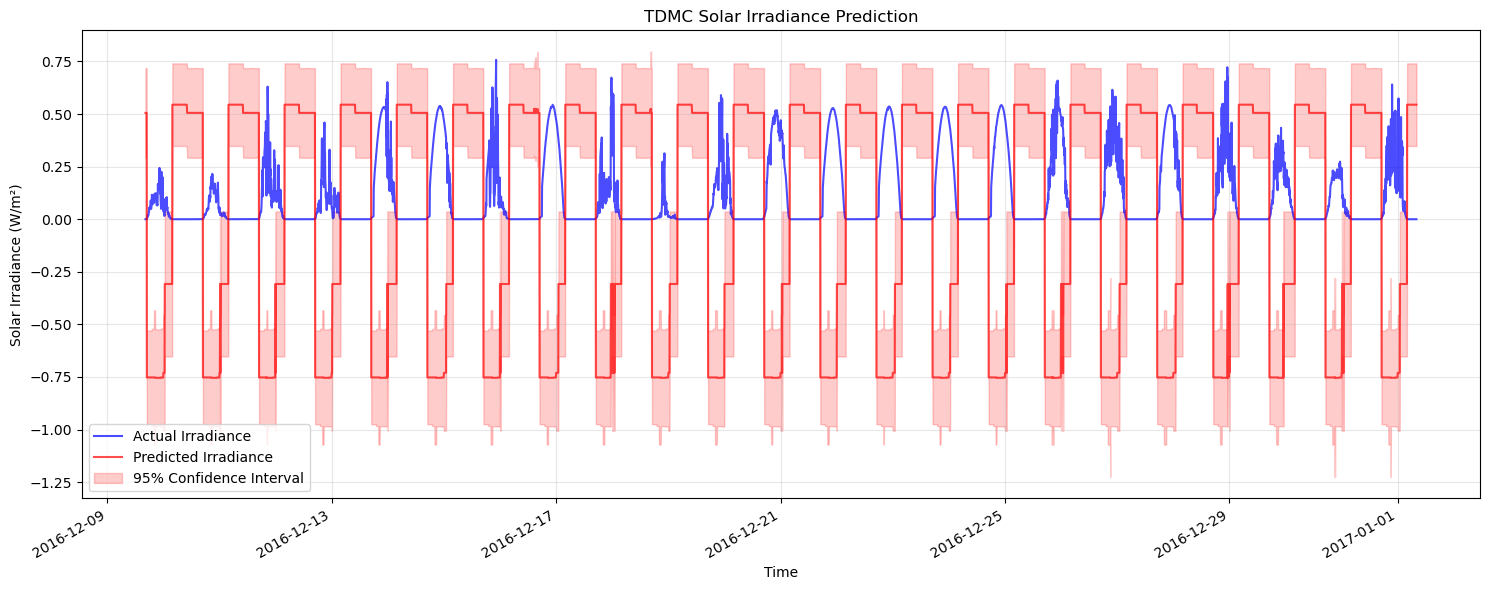

In [9]:
# Generate forecasts
predictions = []
lower_bounds = []
upper_bounds = []

for i in range(len(X_test)):
    if i + 24 > len(X_test):
        break
        
    # Get the current observation window
    last_obs = X_test[i]  # Shape: (24, nfeatures)
    
    # Get the corresponding timestamp
    last_time = timestamps_test[i]  # Scalar timestamp
    


    
    # Forecast next step
    forecast, confidence_intervals = model.forecast(
        last_obs,
        last_time,
        forecast_horizon=2
    )
    
    # Store predictions and confidence intervals
    predictions.append(forecast[0])  # First step prediction
    lower_bounds.append(confidence_intervals[0][0])  # Lower bound
    upper_bounds.append(confidence_intervals[1][0])  # Upper bound

# Convert to numpy arrays
y_pred = np.array(predictions, dtype=float)
lower_bound = np.array(lower_bounds, dtype=float)
upper_bound = np.array(upper_bounds, dtype=float)

# Ensure all arrays are 1D
y_pred = y_pred.flatten()
lower_bound = lower_bound.flatten()
upper_bound = upper_bound.flatten()

# Visualize results
fig = model.plot_prediction_vs_actual(
    y_test[:len(predictions)].flatten(),  # Ensure y_test is 1D
    y_pred,
    timestamps_test[:len(predictions)],  # Use actual timestamp objects
    confidence_intervals=(lower_bound, upper_bound),
    title="TDMC Solar Irradiance Prediction"
)
plt.show()

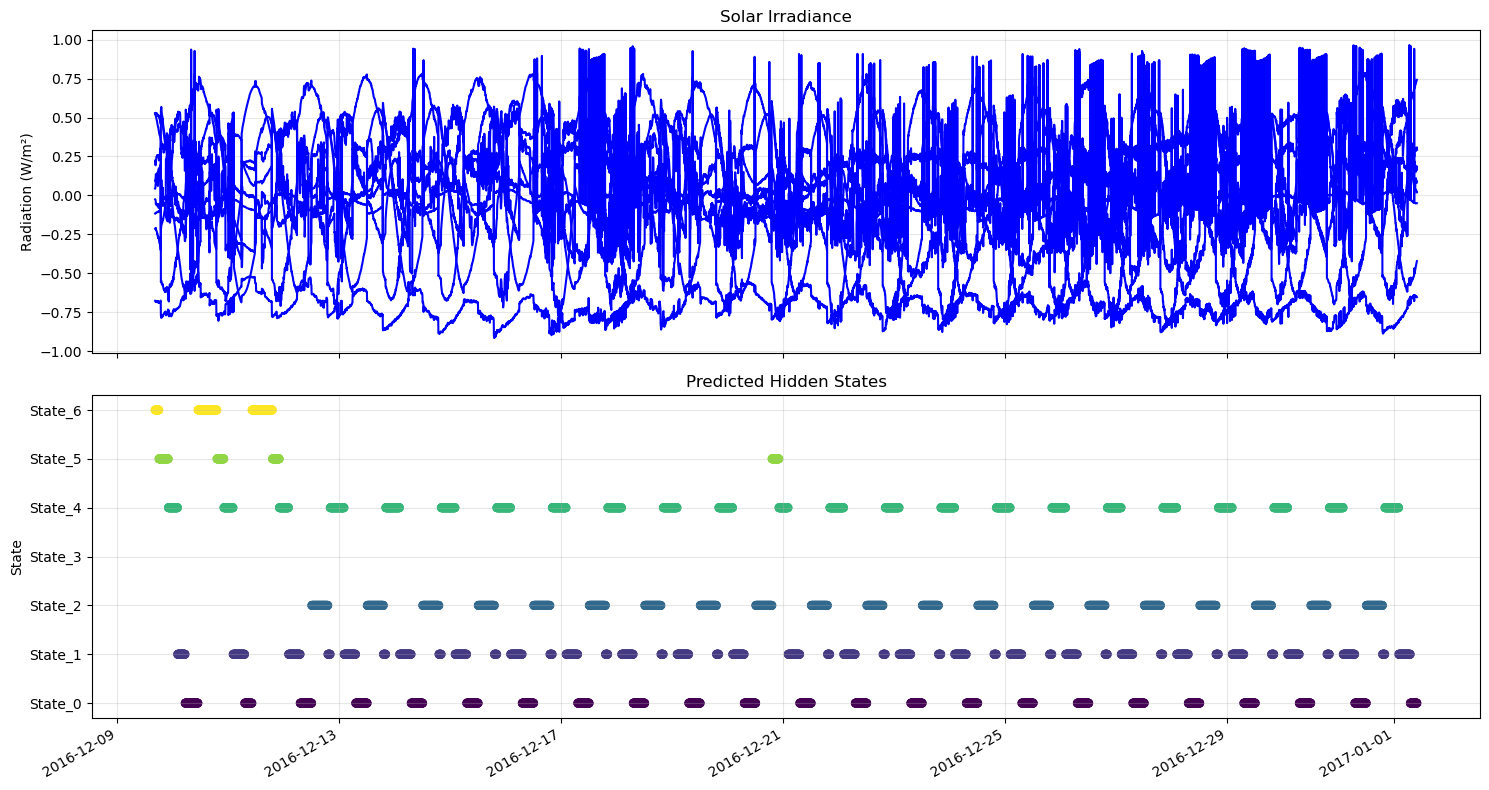

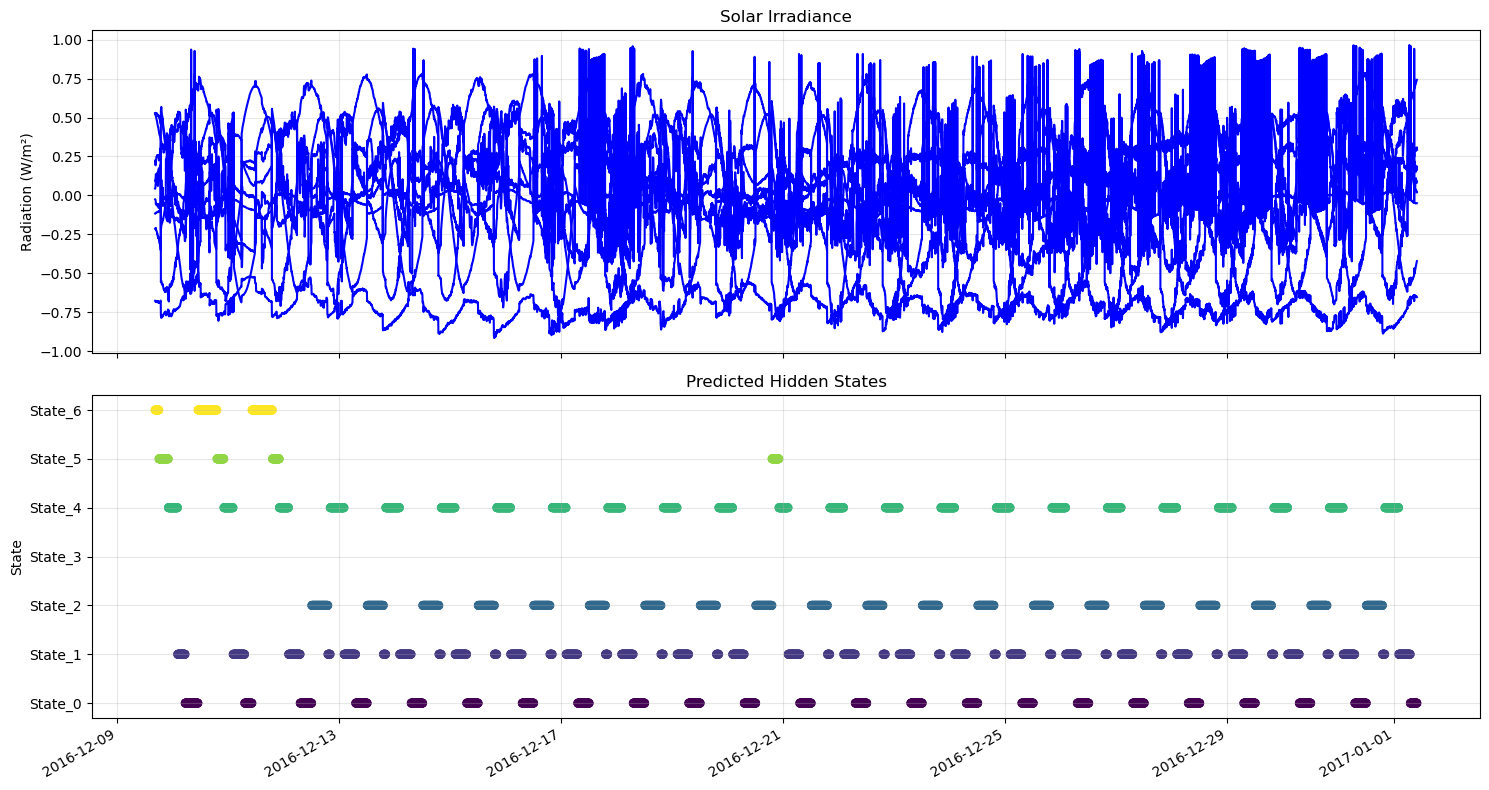

In [10]:
# Visualize hidden states
model.plot_hidden_states(X_test, timestamps_test)



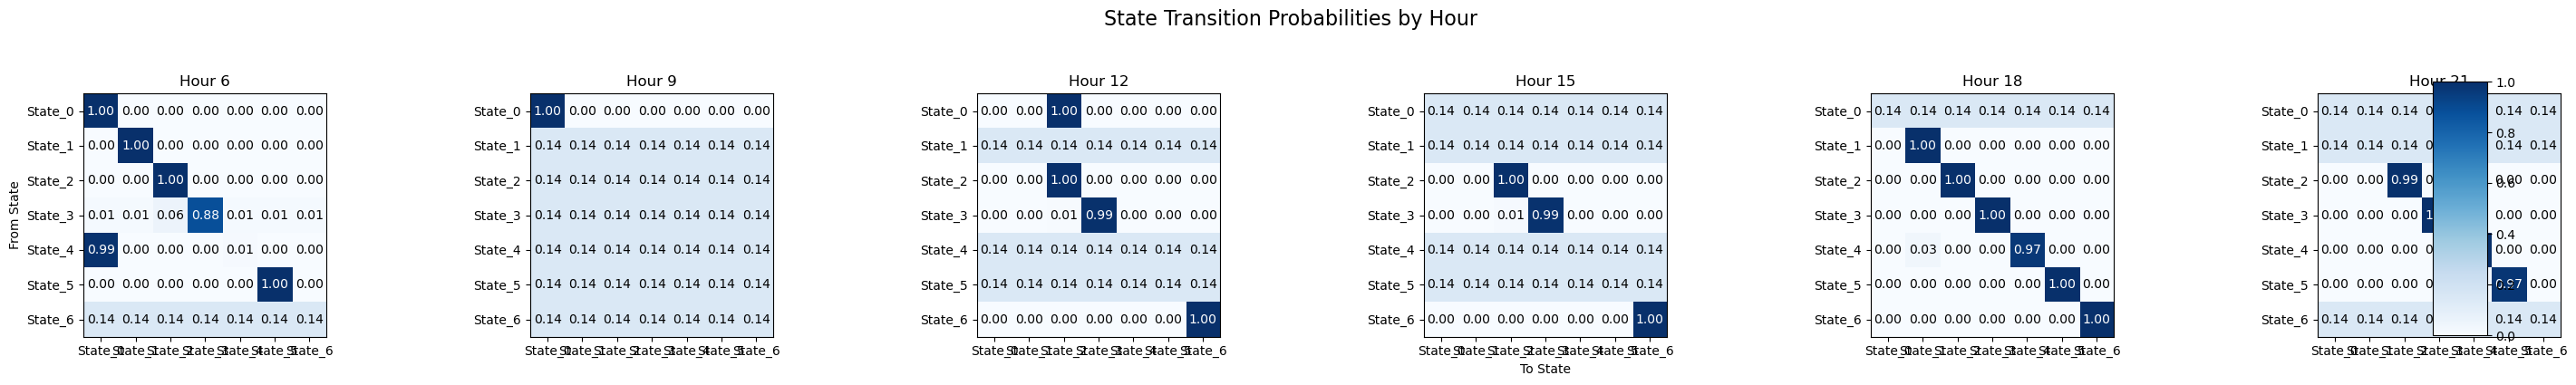

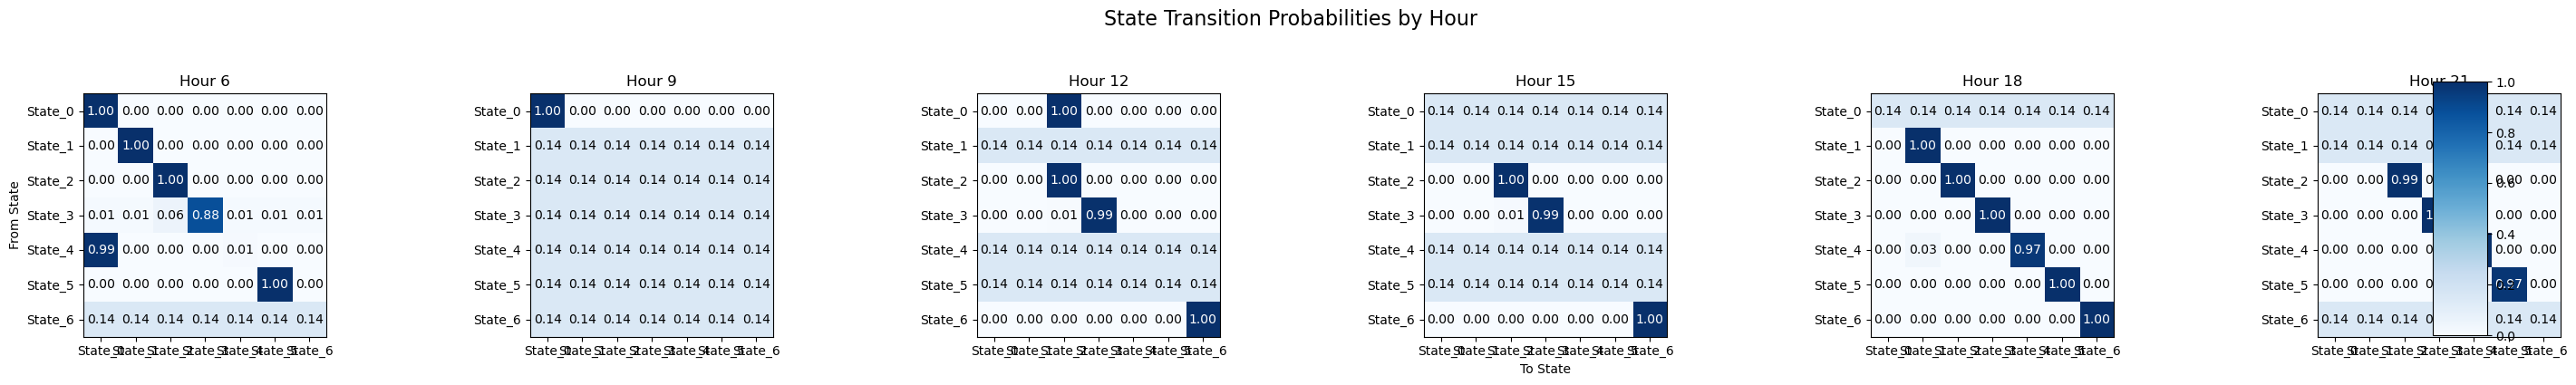

In [11]:
# Visualize transition probabilities
model.plot_transition_heatmaps(hours=[6, 9, 12, 15, 18, 21])


In [12]:

# Visualize state characteristics
model.plot_state_characteristics()


AttributeError: 'SolarTDMC' object has no attribute 'scaler'

In [38]:

# Evaluate multi-step forecasting
model.plot_forecast_horizon_accuracy(X_test, y_test, timestamps_test)

IndexError: invalid index to scalar variable.

In [7]:
# Convert numeric columns
numeric_cols = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 
                   'WindDirection(Degrees)', 'Speed']
    
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Convert timestamps
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
    
# Extract hour for time slices
df['Hour'] = df['Timestamp'].dt.hour

In [ ]:
import tdmc
n_states=3
X = df[['Radiation', 'Temperature']].values
timestamps = df['Hour'].values
# Initialize and train the model
model = tdmc.SolarTDMC(n_states=n_states, n_emissions=2, time_slices=24)

# Define state names based on radiation levels
state_names = [f"State_{i}" for i in range(n_states)]

# Train the model
model.fit(
    X, timestamps, 
    max_iter=50, 
    state_names=state_names
)

In [ ]:
from datetime import datetime, timedelta
def generate_forecast(model, df, forecast_horizon=24):
    """Generate a forecast using the trained TDMC model."""
    
    # Use the last observation as the starting point
    last_obs = df[['Radiation', 'Temperature']].values[-1]
    last_hour = df['Hour'].values[-1]
    
    # Generate forecast
    forecasts, (conf_lower, conf_upper) = model.forecast(
        last_obs, last_hour, forecast_horizon
    )
    
    # Create timestamp range for forecast
    if len(df) > 0:
        last_timestamp = pd.to_datetime(df['Data'].iloc[-1] + ' ' + df['Time'].iloc[-1])
        forecast_times = [last_timestamp + timedelta(hours=i+1) for i in range(forecast_horizon)]
    else:
        # Create default timestamps if dataframe is empty
        start_time = datetime.now()
        forecast_times = [start_time + timedelta(hours=i+1) for i in range(forecast_horizon)]
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'Timestamp': forecast_times,
        'Hour': [t.hour for t in forecast_times],
        'Forecasted_Radiation': forecasts[:, 0],
        'Forecasted_Temperature': forecasts[:, 1],
        'Radiation_Lower_CI': conf_lower[:, 0],
        'Radiation_Upper_CI': conf_upper[:, 0],
        'Temperature_Lower_CI': conf_lower[:, 1],
        'Temperature_Upper_CI': conf_upper[:, 1]
    })
    
    return forecast_df

forecast_df = generate_forecast(model, df, forecast_horizon=24) 
    


In [ ]:
forecast_df

In [20]:
def plot_forecast(forecast_df):
    """Plot the forecasted radiation and temperature."""
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot radiation forecast
    ax1.plot(forecast_df['Timestamp'], forecast_df['Forecasted_Radiation'], 'b-', label='Forecasted Radiation')
    ax1.fill_between(
        forecast_df['Timestamp'],
        forecast_df['Radiation_Lower_CI'],
        forecast_df['Radiation_Upper_CI'],
        alpha=0.3, color='b', label='95% Confidence Interval'
    )
    ax1.set_title('Radiation Forecast')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Radiation')
    ax1.legend()
    ax1.grid(True)
    
    # Plot temperature forecast
    ax2.plot(forecast_df['Timestamp'], forecast_df['Forecasted_Temperature'], 'r-', label='Forecasted Temperature')
    ax2.fill_between(
        forecast_df['Timestamp'],
        forecast_df['Temperature_Lower_CI'],
        forecast_df['Temperature_Upper_CI'],
        alpha=0.3, color='r', label='95% Confidence Interval'
    )
    ax2.set_title('Temperature Forecast')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature (°F)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig


In [ ]:
fig = plot_forecast(forecast_df)
plt.show()

In [41]:
    # Test the Markov property
markov_test = tdmc.plot_
print(f"\nMarkov Property Test: {markov_test['result']}")
print(f"Message: {markov_test['message']}")
    


AttributeError: module 'tdmc' has no attribute 'plot_'

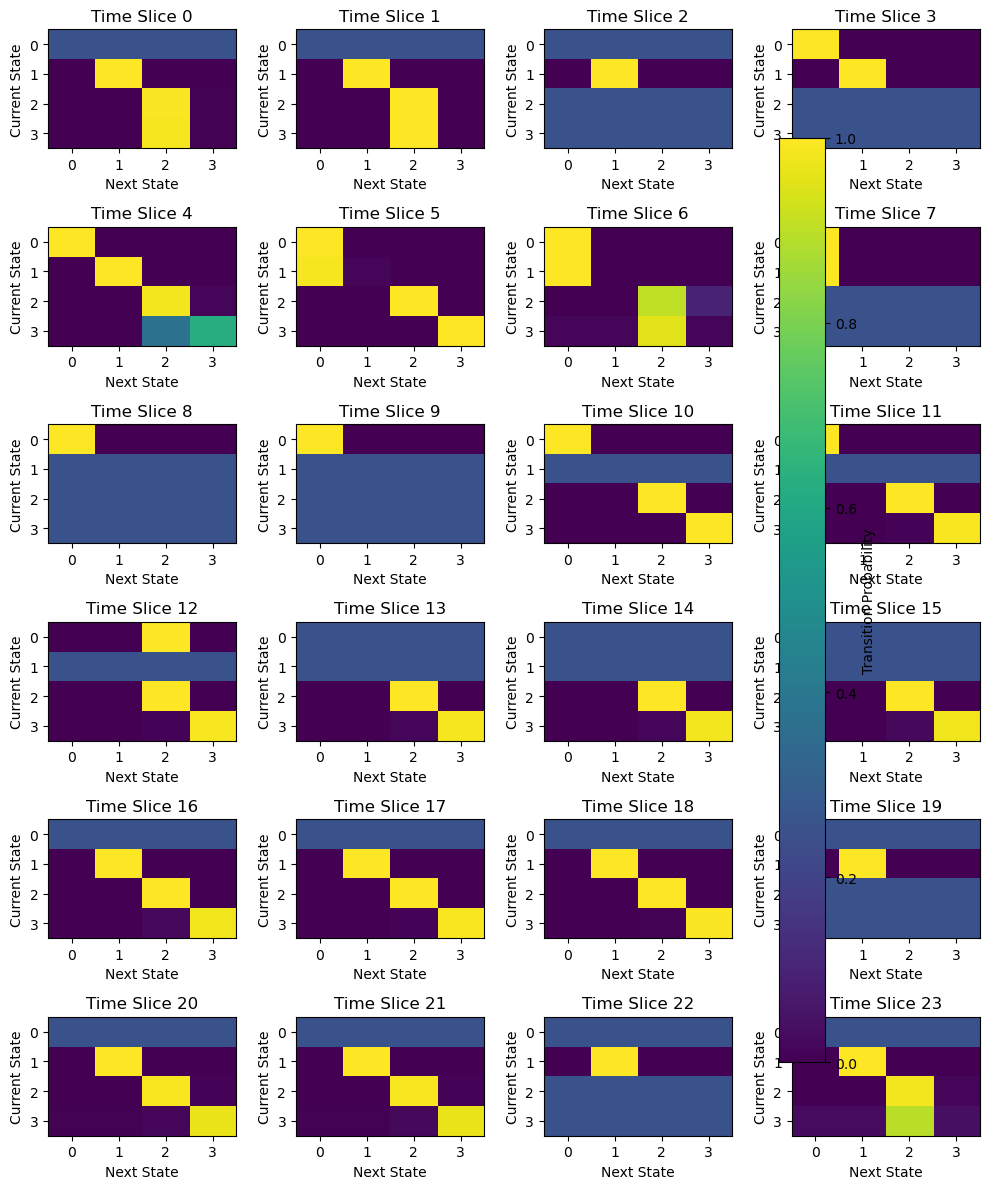

In [42]:
# Plot the transition matrix
model.plot_transition_matrix()
    


In [43]:
# Plot state distributions for the first two features
model.plot_state_distributions([0, 1])

AttributeError: 'SolarTDMC' object has no attribute 'plot_state_distributions'